<a href="https://colab.research.google.com/github/brendaFlavia/DeepLearningAssignment/blob/main/LungOpacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import glob
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, utils, losses, callbacks
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, accuracy_score, roc_auc_score

In [9]:
data_dir = "/content/gdrive/MyDrive/DeepLearning/dataset1"
#test_data_dir = "/content/gdrive/MyDrive/dataset1/known_images"
#validation_dir="/content/gdrive/MyDrive/dataset1/known_images"

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

import pathlib
#train and Validation data directory 
data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset1') 

#test data directory
test_data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/unknown_images') 



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
img_width, img_height = 391,488
batch_size = 10

In [12]:
# Define image data generators
# Train data


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 715 files belonging to 2 classes.
Using 572 files for training.


In [ ]:
# Test generator
#test_generator = image.ImageDataGenerator(rescale=1./255)

In [13]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 715 files belonging to 2 classes.
Using 143 files for validation.


In [ ]:
#test dataset


In [14]:
#batch_size=10
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=50
  )


Found 50 files belonging to 1 classes.


In [15]:
# Load class names for the dataset
class_names = train_ds.class_names
print(class_names)

['normal', 'sick']


In [ ]:
#Virtualize the training dataset

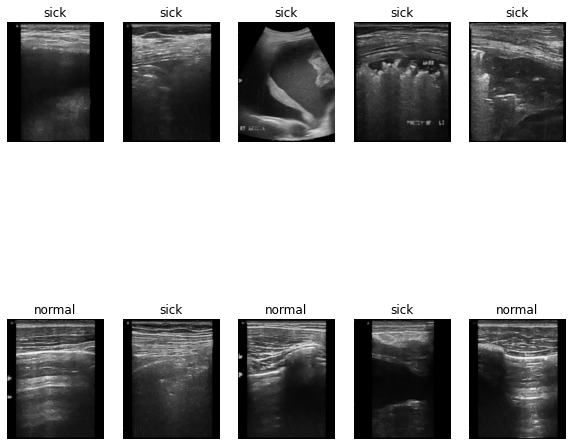

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#print shape the training dataset

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 488, 391, 3)
(10,)


In [ ]:
#print shape of test dataset

In [22]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 488, 391, 3)
(50,)


In [21]:
#print shape of validation dataset

In [23]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 488, 391, 3)
(10,)


In [ ]:
#normalize the dataset

In [24]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [32]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[8]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9921569


In [30]:
normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[9]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9693797


In [31]:
normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[20]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9913947


In [ ]:
#configure dataset for performance

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [34]:
#create a model
model = models.Sequential()

In [38]:
num_classes = num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='sigmoid')
])

In [ ]:
#complie the model

In [39]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#model.summary()

In [ ]:
#fit the model with training dataset

In [83]:
result=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
)

Epoch 1/5
58/58 [==============================] - 140s 2s/step - loss: 0.1009 - accuracy: 0.9493 - val_loss: 0.1182 - val_accuracy: 0.9580
Epoch 2/5
58/58 [==============================] - 135s 2s/step - loss: 0.0826 - accuracy: 0.9703 - val_loss: 0.4309 - val_accuracy: 0.8252
Epoch 3/5
58/58 [==============================] - 135s 2s/step - loss: 0.0965 - accuracy: 0.9545 - val_loss: 0.1319 - val_accuracy: 0.9441
Epoch 4/5
58/58 [==============================] - 135s 2s/step - loss: 0.1373 - accuracy: 0.9371 - val_loss: 0.0844 - val_accuracy: 0.9720
Epoch 5/5
58/58 [==============================] - 135s 2s/step - loss: 0.0757 - accuracy: 0.9563 - val_loss: 0.0918 - val_accuracy: 0.9720


In [42]:


test_loss, test_acc = model.evaluate(val_ds, verbose=2)



15/15 - 7s - loss: 0.1675 - accuracy: 0.9720 - 7s/epoch - 469ms/step


In [41]:
#Visualize training results

Text(0.5, 1.0, 'Training and Validation Accuracy')

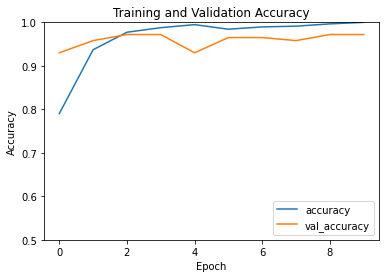

In [43]:
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
#print accauracy

In [44]:
print(test_acc)

0.9720279574394226


Text(0.5, 1.0, 'Training and Validation Loss')

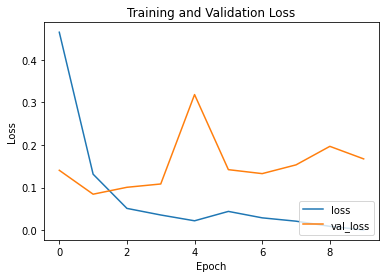

In [45]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
#Test the model

In [ ]:
#load test data

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

import pathlib
test_data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/unknown_images') 



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Predictions:
 [0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0
 0 0 1 1 0 0 1 0 1 0 1 1 0]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


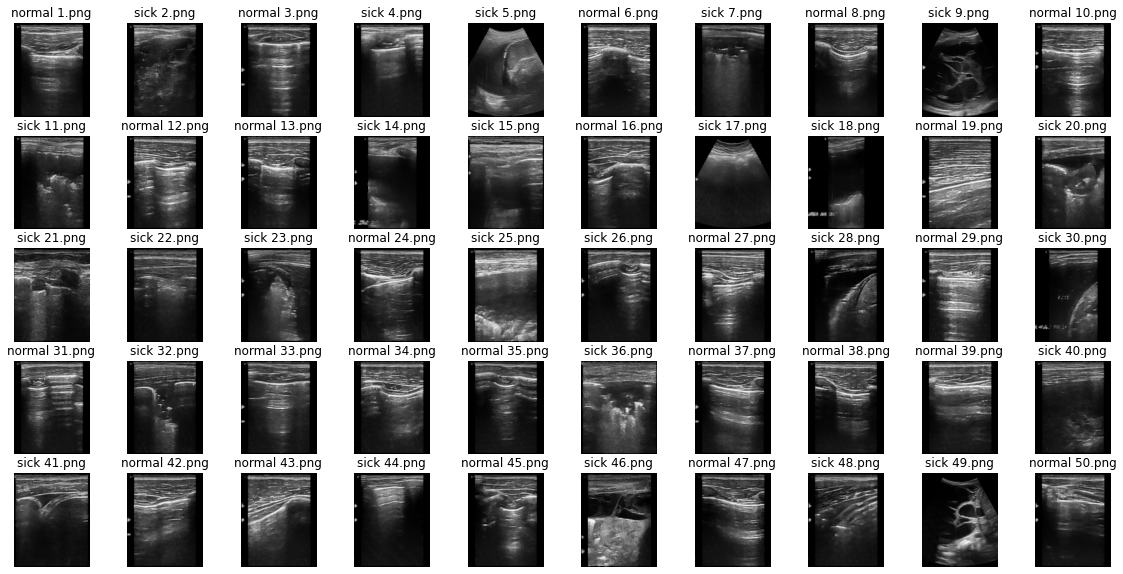

In [47]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]]+ ' '+ str(i+1)+'.png')
  plt.axis("off")

In [ ]:
#Introduce Data Augumentation

In [49]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
#visualize augumented images

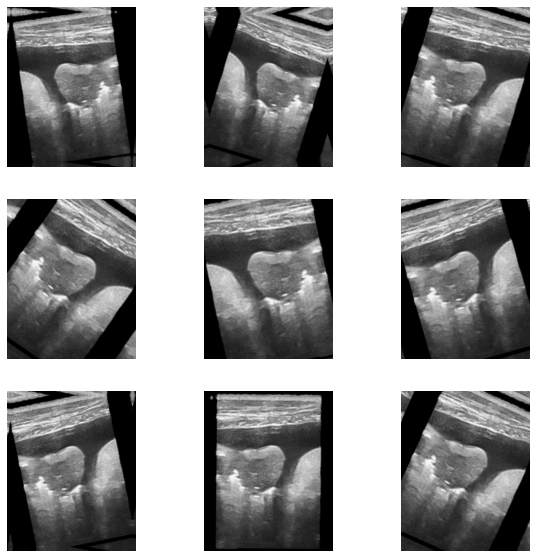

In [50]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#Build model with data augumentation

In [51]:

model = tf.keras.Sequential([
    data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [52]:
#complie model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 488, 391, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 488, 391, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 486, 389, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 243, 194, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 241, 192, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 120, 96, 32)      0         
 2D)                                                  

In [53]:
#fit the model

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
58/58 [==============================] - 137s 2s/step - loss: 0.4821 - accuracy: 0.7675 - val_loss: 0.2644 - val_accuracy: 0.8811
Epoch 2/15
58/58 [==============================] - 136s 2s/step - loss: 0.3017 - accuracy: 0.8531 - val_loss: 0.2362 - val_accuracy: 0.9021
Epoch 3/15
58/58 [==============================] - 136s 2s/step - loss: 0.2942 - accuracy: 0.8741 - val_loss: 0.1836 - val_accuracy: 0.9231
Epoch 4/15
58/58 [==============================] - 135s 2s/step - loss: 0.3176 - accuracy: 0.8671 - val_loss: 0.1654 - val_accuracy: 0.9231
Epoch 5/15
58/58 [==============================] - 135s 2s/step - loss: 0.2231 - accuracy: 0.9213 - val_loss: 0.2270 - val_accuracy: 0.9091
Epoch 6/15
58/58 [==============================] - 135s 2s/step - loss: 0.2554 - accuracy: 0.8811 - val_loss: 0.1849 - val_accuracy: 0.9091
Epoch 7/15
58/58 [==============================] - 135s 2s/step - loss: 0.1954 - accuracy: 0.9108 - val_loss: 0.1376 - val_accuracy: 0.9441
Epoch 8/15
58

In [ ]:
#Visualizing results after adding data augumentation

In [54]:
print(test_acc)

0.9720279574394226


Text(0.5, 1.0, 'Training and Validation Accuracy')

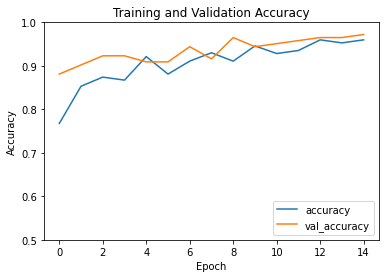

In [55]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

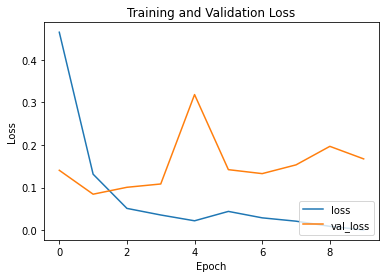

In [56]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
#using drop out to reduce overfitting the model

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
#complie model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 488, 391, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 488, 391, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 486, 389, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 243, 194, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 241, 192, 32)      9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 120, 96, 32)      0         
 g2D)                                                

In [ ]:
#test model

#fit the model

epochs = 25
history_t = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
58/58 [==============================] - 146s 2s/step - loss: 0.5708 - accuracy: 0.7500 - val_loss: 0.2521 - val_accuracy: 0.8951
Epoch 2/25
58/58 [==============================] - 143s 2s/step - loss: 0.3336 - accuracy: 0.8392 - val_loss: 0.2177 - val_accuracy: 0.9091
Epoch 3/25
58/58 [==============================] - 143s 2s/step - loss: 0.3414 - accuracy: 0.8322 - val_loss: 0.2228 - val_accuracy: 0.8881
Epoch 4/25
58/58 [==============================] - 145s 2s/step - loss: 0.3104 - accuracy: 0.8776 - val_loss: 0.1931 - val_accuracy: 0.9091
Epoch 5/25
58/58 [==============================] - 143s 2s/step - loss: 0.2317 - accuracy: 0.9038 - val_loss: 0.2221 - val_accuracy: 0.9231
Epoch 6/25
58/58 [==============================] - 143s 2s/step - loss: 0.2938 - accuracy: 0.8794 - val_loss: 0.1951 - val_accuracy: 0.9021
Epoch 7/25
58/58 [==============================] - 142s 2s/step - loss: 0.2223 - accuracy: 0.9003 - val_loss: 0.4501 - val_accuracy: 0.8462
Epoch 8/25
58

Predictions:
 [0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 0 0 1 1 1 0 0 0 1 0 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


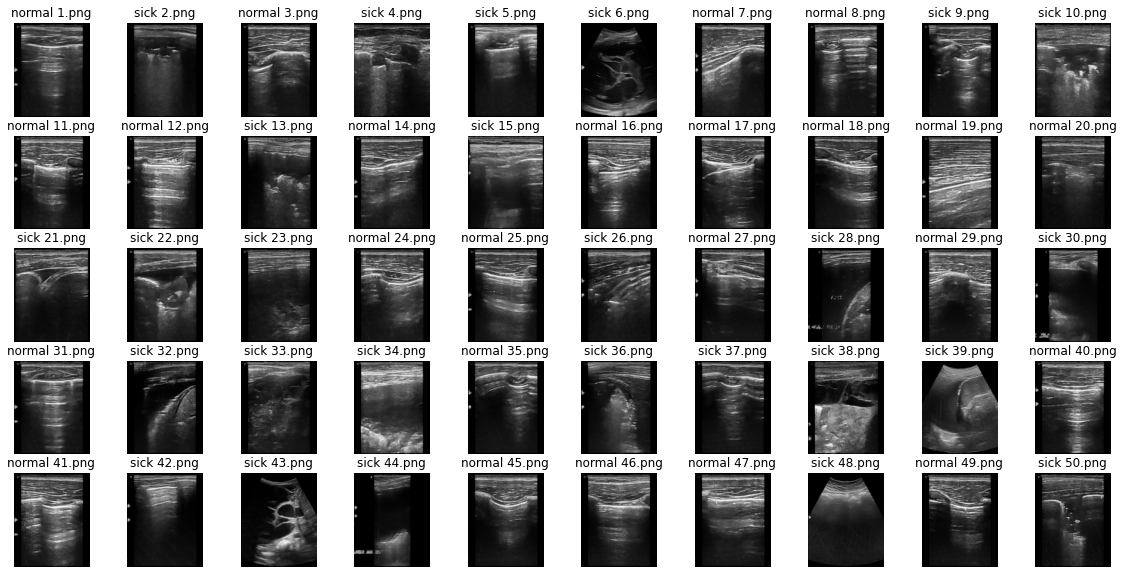

In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]]+ ' '+ str(i+1)+'.png')
  plt.axis("off")

In [ ]:


# dataset two

In [72]:
from google.colab import drive
drive.mount('/content/gdrive')

dataset2 = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset2/images/sick_eff0.png') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#prdict the class of images in dataset 2

In [82]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
dataset2 = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset2/images/sick_eff11.png') 

#image_path = tf.keras.utils.get_file('Known_image', origin=dataset2)

img = tf.keras.utils.load_img(
    dataset2, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sick with a 100.00 percent confidence.
